In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
df=  pd.read_csv('CSV87 dane.csv',sep=';', decimal=',',index_col='Data godzina')

In [33]:
start = datetime.datetime.strptime("01-01-2017 1:00", "%d-%m-%Y %H:%M")
date_list = [start + relativedelta(hours=x) for x in range(0,11544)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

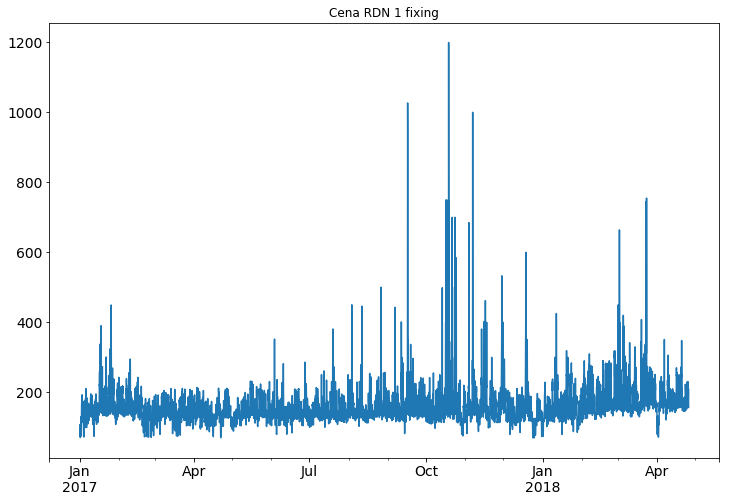

In [34]:
%matplotlib inline
df['RDN 1fix'].plot(figsize=(12,8), title= 'Cena RDN 1 fixing', fontsize=14)

In [35]:
b=df['RDN 1fix'][0:-24:]
feature_cols = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh'] 
X = df[feature_cols][0:-24:]
feature_cols2 = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh','Emisja CO2 EUR/Tona','Observation Poland National (C)']
X2 = df[feature_cols2][0:-24:]
feature_cols3 = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh','Generacja nJWCD w MWh','Wymagana rezerwa mocy w MWh','Emisja CO2 EUR/Tona','Observation Poland National (C)']
X3= df[feature_cols3][0:-24:]

<Figure size 432x288 with 0 Axes>

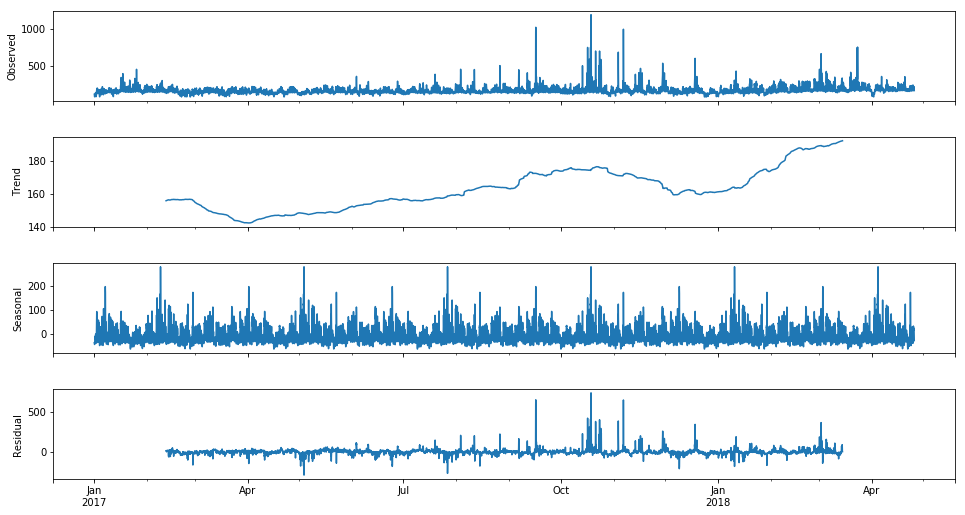

In [94]:
decomposition = seasonal_decompose(b,freq=24*7*12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


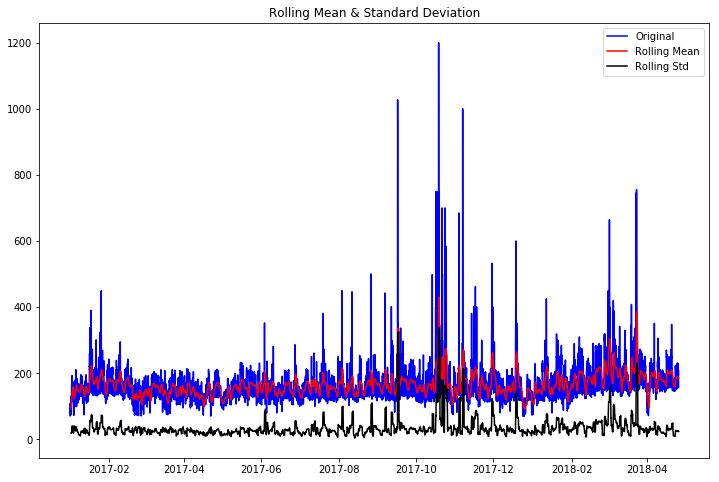

Results of Dickey-Fuller Test:
Test Statistic                -1.180993e+01
p-value                        8.910363e-22
#Lags Used                     4.000000e+01
Number of Observations Used    1.147900e+04
Critical Value (1%)           -3.430920e+00
Critical Value (5%)           -2.861792e+00
Critical Value (10%)          -2.566904e+00
dtype: float64


In [8]:
test_stationarity(b)

In [64]:
## niewielkie wartości p-value wskazują na stacjonarność i odrzucenie Hipotezy zerowej mówiącej o 
#występowaniu pierwiastka jednostkowego

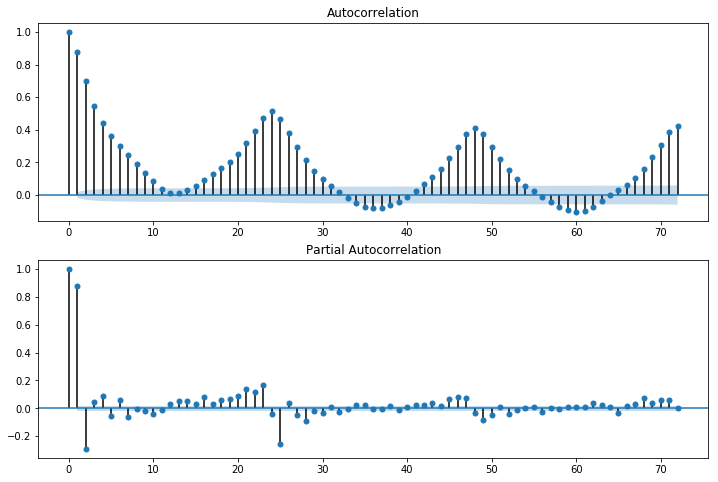

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(b, lags=72, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(b, lags=72, ax=ax2)

In [30]:
model = sm.tsa.statespace.SARIMAX(b ,trend='n', order=(2,0,0), seasonal_order=(0,1,1,24))
results1 = model.fit()
print (results1.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           RDN 1fix   No. Observations:                11520
Model:             SARIMAX(2, 0, 0)x(0, 1, 1, 24)   Log Likelihood              -52693.206
Date:                            Tue, 21 Aug 2018   AIC                         105394.412
Time:                                    00:27:04   BIC                         105423.811
Sample:                                01-01-2017   HQIC                        105404.294
                                     - 04-26-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0071      0.002    527.651      0.000       1.003       1.011
ar.L2         -0.1809      0.002   

In [12]:
model = sm.tsa.statespace.SARIMAX(b, exog=X,trend='ct', order=(2,0,0), seasonal_order=(0,0,0,24))
results2 = model.fit()
print (results2.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:               RDN 1fix   No. Observations:                11520
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -52958.698
Date:                Tue, 21 Aug 2018   AIC                         105933.396
Time:                        00:02:07   BIC                         105992.211
Sample:                    01-01-2017   HQIC                        105953.165
                         - 04-26-2018                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -4.5225      1.428     -3.166      0.002      -7.322      -1.723
drift                                  0.0007      0.000   

In [23]:
model = sm.tsa.statespace.SARIMAX(b, exog=X,trend='ct', order=(2,0,0), seasonal_order=(2,0,0,24))
results3 = model.fit()
print (results3.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           RDN 1fix   No. Observations:                11520
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood              -52517.191
Date:                            Tue, 21 Aug 2018   AIC                         105054.383
Time:                                    00:22:00   BIC                         105127.901
Sample:                                01-01-2017   HQIC                        105079.094
                                     - 04-26-2018                                         
Covariance Type:                              opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -4.5221      1.230     -3.67

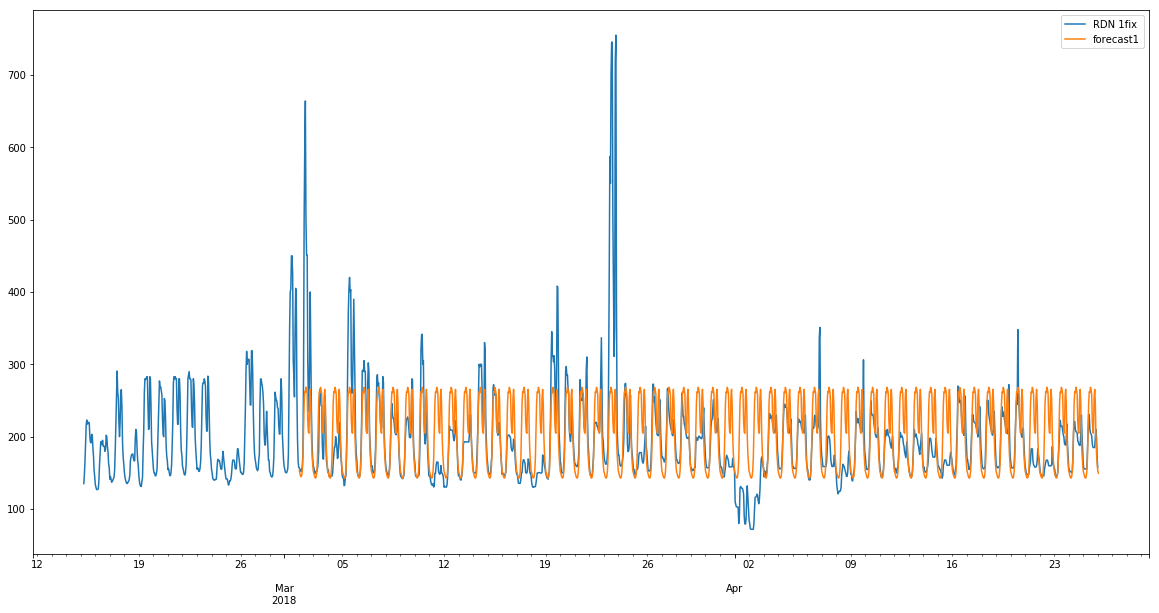

In [36]:
df['forecast1'] = results1.predict(start = 10200, end= 11520, dynamic= True)  
df[['RDN 1fix', 'forecast1']][-1700:].plot(figsize=(20, 10))

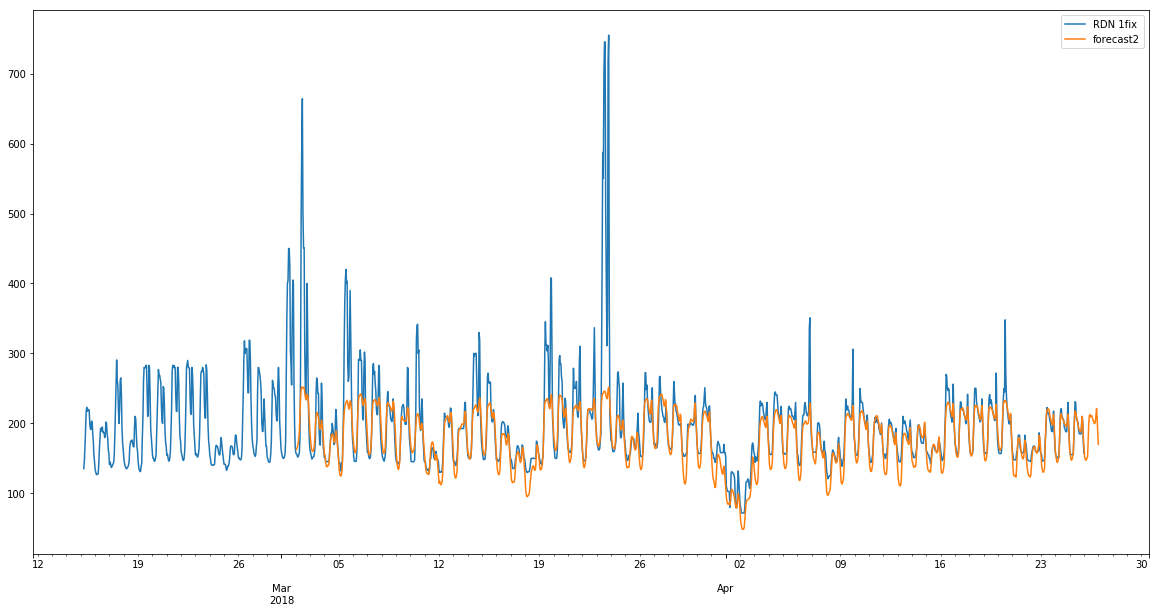

In [57]:
Xoos=df[feature_cols][-24:] ##tutaj exogeniczne do ostatnich 24h jako wsad do prognozy do pierwszego modelu
df['forecast2'] = results2.predict(start = 10200, end= 11543, dynamic= True,exog=Xoos)  
df[['RDN 1fix', 'forecast2']][-1700:].plot(figsize=(20, 10))

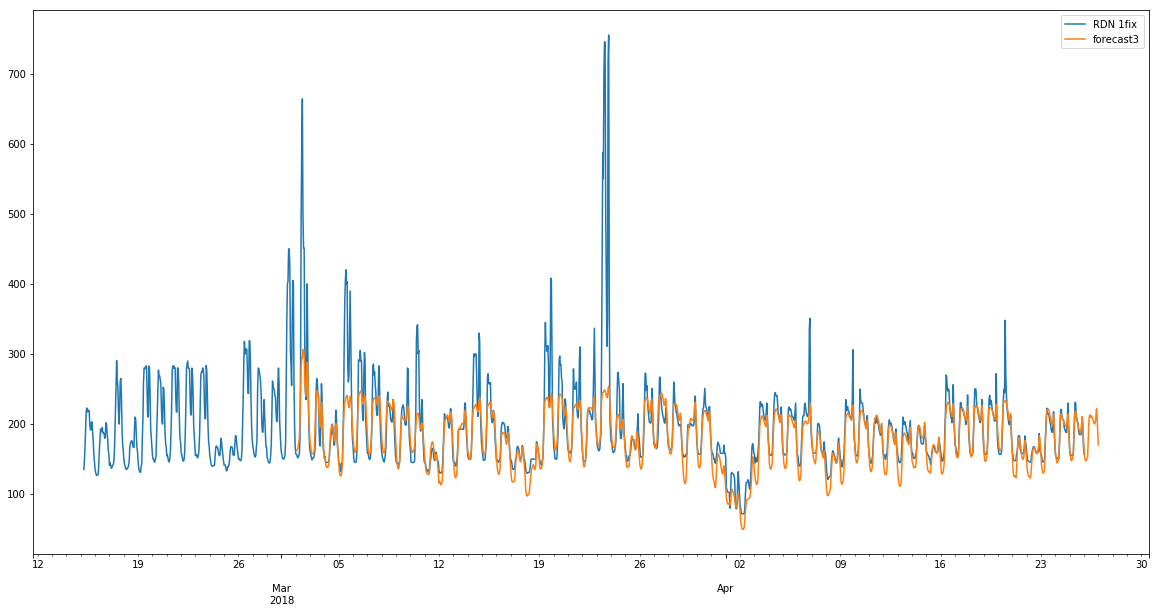

In [37]:
df['forecast3'] = results3.predict(start = 10200, end= 11543, dynamic= True, exog=Xoos)  
df[['RDN 1fix', 'forecast3']][-1700:].plot(figsize=(20, 10))

In [181]:
Xoos=df[feature_cols][-24:] ##tutaj exogeniczne do ostatnich 24h jako wsad do prognozy do pierwszego modelu
print(Xoos)

                     Generacja wiatraków(PSE) w MWh  \
2018-04-26 01:00:00                          1613.0   
2018-04-26 02:00:00                          1443.0   
2018-04-26 03:00:00                          1329.0   
2018-04-26 04:00:00                          1283.0   
2018-04-26 05:00:00                          1265.0   
2018-04-26 06:00:00                          1280.0   
2018-04-26 07:00:00                          1292.0   
2018-04-26 08:00:00                          1309.0   
2018-04-26 09:00:00                          1360.0   
2018-04-26 10:00:00                          1509.0   
2018-04-26 11:00:00                          1686.0   
2018-04-26 12:00:00                          1790.0   
2018-04-26 13:00:00                          1832.0   
2018-04-26 14:00:00                          1863.0   
2018-04-26 15:00:00                          1871.0   
2018-04-26 16:00:00                          1859.0   
2018-04-26 17:00:00                          1811.0   
2018-04-26

In [166]:
#start = datetime.datetime.strptime("2018-04-26 02:00", "%Y-%m-%d %H:%M") ## tutaj auto of sample bez egzogenicznych
#date_list = [start + relativedelta(hours=x) for x in range(0,24)]
#future = pd.DataFrame(index=date_list, columns= df.columns)
#df = pd.concat([df, future])#

In [58]:
wyniki = pd.DataFrame()
wyniki['Actual']= df['RDN 1fix'][10200:11520]
wyniki['predicted']= df['forecast2'][10200:11520]
wyniki.columns=['Actual','predicted']
#wyniki=wyniki.sort_values(by=['Actual'])#
wyniki['index']=range(len(wyniki))

In [59]:
from sklearn.metrics import r2_score   #błędy modelu nr. 2##
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from math import sqrt
r=r2_score(wyniki['Actual'],wyniki['predicted'])
msle=mean_squared_log_error(wyniki['Actual'],wyniki['predicted'])
mse=mean_squared_error(wyniki['Actual'],wyniki['predicted'])
mae=mean_absolute_error(wyniki['Actual'],wyniki['predicted'])
evs=explained_variance_score(wyniki['Actual'],wyniki['predicted'])
medianae=median_absolute_error(wyniki['Actual'],wyniki['predicted'])
mape=np.mean(np.abs((wyniki['Actual'] -wyniki['predicted']) / wyniki['Actual'])) * 100
rmse=sqrt(mean_squared_error(wyniki['Actual'],wyniki['predicted']))
bledy1= np.array([['r2_score','mean squared log error','mean squared error','mean absolute error','explained variance score','median absolute error','MAPE','RMSE'],[r,msle,mse,mae,evs,medianae,mape,rmse]],dtype='U25')
df2 = pd.DataFrame(data=bledy1,columns=bledy1[0])
Bledy2=df2.drop(0)
Bledy2.head()

,r2_score,mean squared log error,mean squared error,mean absolute error,explained variance score,median absolute error,MAPE,RMSE
1,0.47054212699846865,0.024121228212245504,2239.418781729714,20.01437828243653,0.5223031956786214,10.589257496490632,8.659115161325103,47.32249762776384


In [60]:
wyniki2 = pd.DataFrame()
wyniki2['Actual']= df['RDN 1fix'][10200:11520]
wyniki2['predicted']= df['forecast3'][10200:11520]
wyniki2.columns=['Actual','predicted']
#wyniki=wyniki.sort_values(by=['Actual'])#
wyniki2['index']=range(len(wyniki))

In [61]:
from sklearn.metrics import r2_score   #błędy modelu #nr3#
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from math import sqrt
r=r2_score(wyniki2['Actual'],wyniki2['predicted'])
msle=mean_squared_log_error(wyniki2['Actual'],wyniki2['predicted'])
mse=mean_squared_error(wyniki2['Actual'],wyniki2['predicted'])
mae=mean_absolute_error(wyniki2['Actual'],wyniki2['predicted'])
evs=explained_variance_score(wyniki2['Actual'],wyniki2['predicted'])
medianae=median_absolute_error(wyniki2['Actual'],wyniki2['predicted'])
mape=np.mean(np.abs((wyniki2['Actual'] -wyniki2['predicted']) / wyniki2['Actual'])) * 100
rmse=sqrt(mean_squared_error(wyniki2['Actual'],wyniki2['predicted']))
bledy1= np.array([['r2_score','mean squared log error','mean squared error','mean absolute error','explained variance score','median absolute error','MAPE','RMSE'],[r,msle,mse,mae,evs,medianae,mape,rmse]],dtype='U25')
df3 = pd.DataFrame(data=bledy1,columns=bledy1[0])
Bledy3=df3.drop(0)
Bledy3.head()

,r2_score,mean squared log error,mean squared error,mean absolute error,explained variance score,median absolute error,MAPE,RMSE
1,0.5154204850082763,0.02136956826649907,2049.599264549614,18.974919884922844,0.5541753728233688,10.110682635031438,8.24548935506367,45.27250009166286


In [66]:
wyniki.tail(48)

,Actual,predicted,index
2018-04-24 01:00:00,153.81,153.211432,1272
2018-04-24 02:00:00,152.21,147.708189,1273
2018-04-24 03:00:00,151.61,144.229660,1274
2018-04-24 04:00:00,151.74,145.577376,1275
2018-04-24 05:00:00,150.00,148.593560,1276
2018-04-24 06:00:00,152.26,152.844924,1277
2018-04-24 07:00:00,172.92,178.206512,1278
2018-04-24 08:00:00,205.00,203.695156,1279
2018-04-24 09:00:00,220.60,213.549507,1280
2018-04-24 10:00:00,221.00,213.706274,1281


In [65]:
wyniki2.tail(48)

,Actual,predicted,index
2018-04-24 01:00:00,153.81,153.499957,1272
2018-04-24 02:00:00,152.21,147.963992,1273
2018-04-24 03:00:00,151.61,144.482013,1274
2018-04-24 04:00:00,151.74,145.836561,1275
2018-04-24 05:00:00,150.00,148.866861,1276
2018-04-24 06:00:00,152.26,153.175480,1277
2018-04-24 07:00:00,172.92,178.738059,1278
2018-04-24 08:00:00,205.00,204.415450,1279
2018-04-24 09:00:00,220.60,214.325272,1280
2018-04-24 10:00:00,221.00,214.471708,1281


In [67]:
df['forecast3'][-24:] ## tutaj prognoza na dzień nastepny 26.04

2018-04-26 01:00:00    152.340780
2018-04-26 02:00:00    148.870578
2018-04-26 03:00:00    147.288432
2018-04-26 04:00:00    147.945418
2018-04-26 05:00:00    150.843145
2018-04-26 06:00:00    152.274939
2018-04-26 07:00:00    178.232180
2018-04-26 08:00:00    201.896616
2018-04-26 09:00:00    211.722586
2018-04-26 10:00:00    213.108002
2018-04-26 11:00:00    209.607117
2018-04-26 12:00:00    211.602818
2018-04-26 13:00:00    211.566989
2018-04-26 14:00:00    209.025943
2018-04-26 15:00:00    205.703257
2018-04-26 16:00:00    203.941026
2018-04-26 17:00:00    200.599247
2018-04-26 18:00:00    200.207774
2018-04-26 19:00:00    202.952235
2018-04-26 20:00:00    211.929513
2018-04-26 21:00:00    221.972383
2018-04-26 22:00:00    208.267925
2018-04-26 23:00:00    187.138517
2018-04-27 00:00:00    170.218742
Name: forecast3, dtype: float64

Figure(2160x2160)


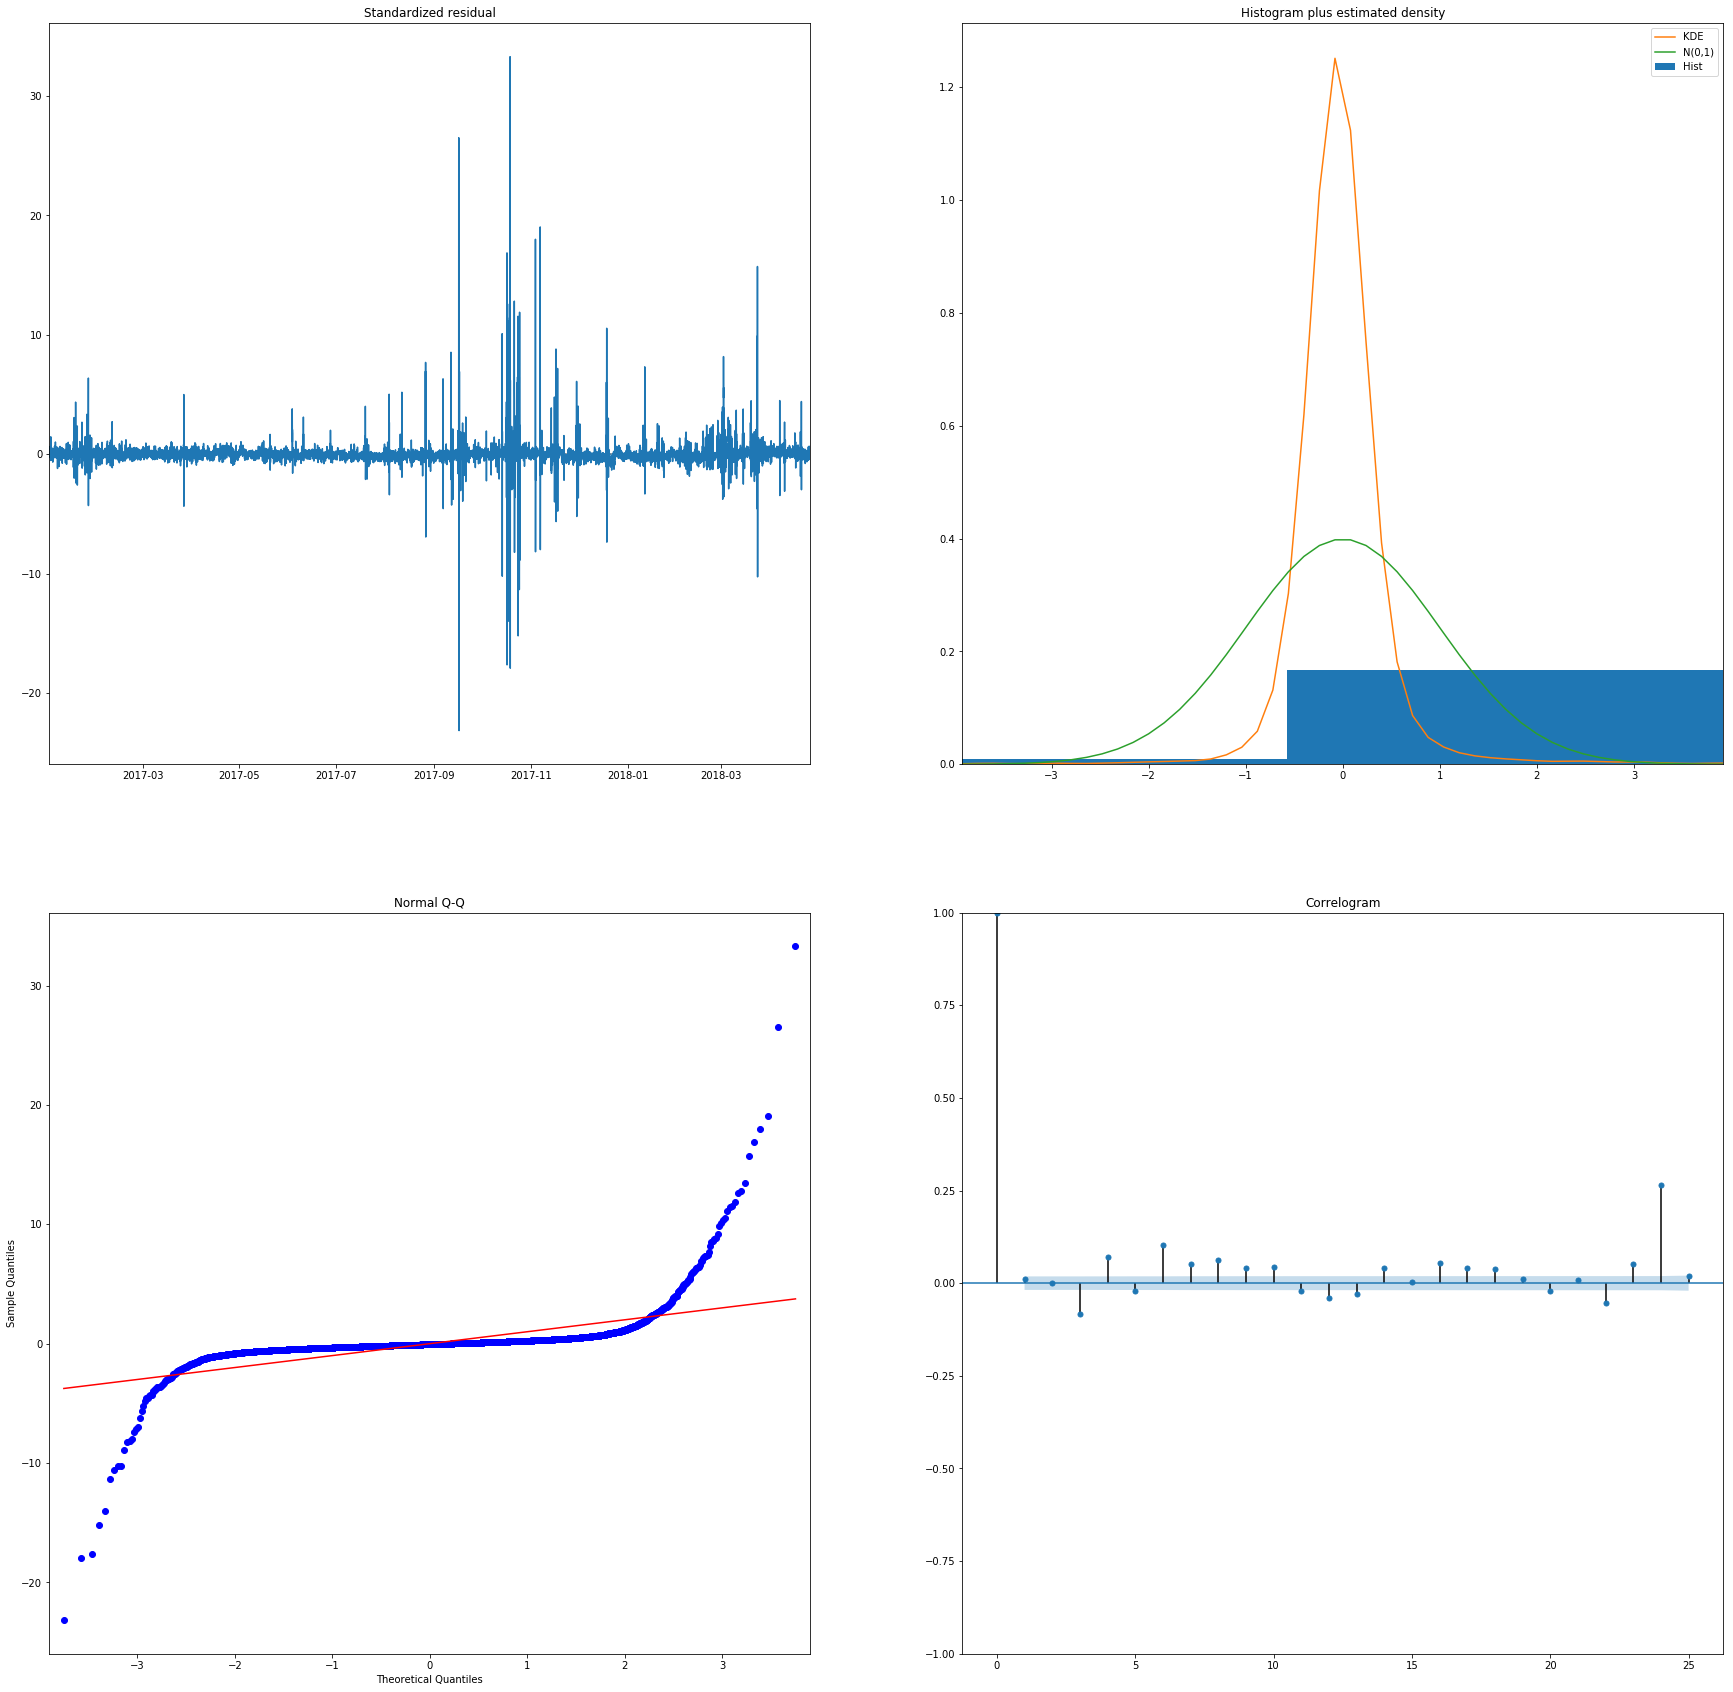

In [107]:
print(results2.plot_diagnostics(lags=25,figsize=(30,30))) ##testowanie reszt modelu##

Figure(2160x2160)


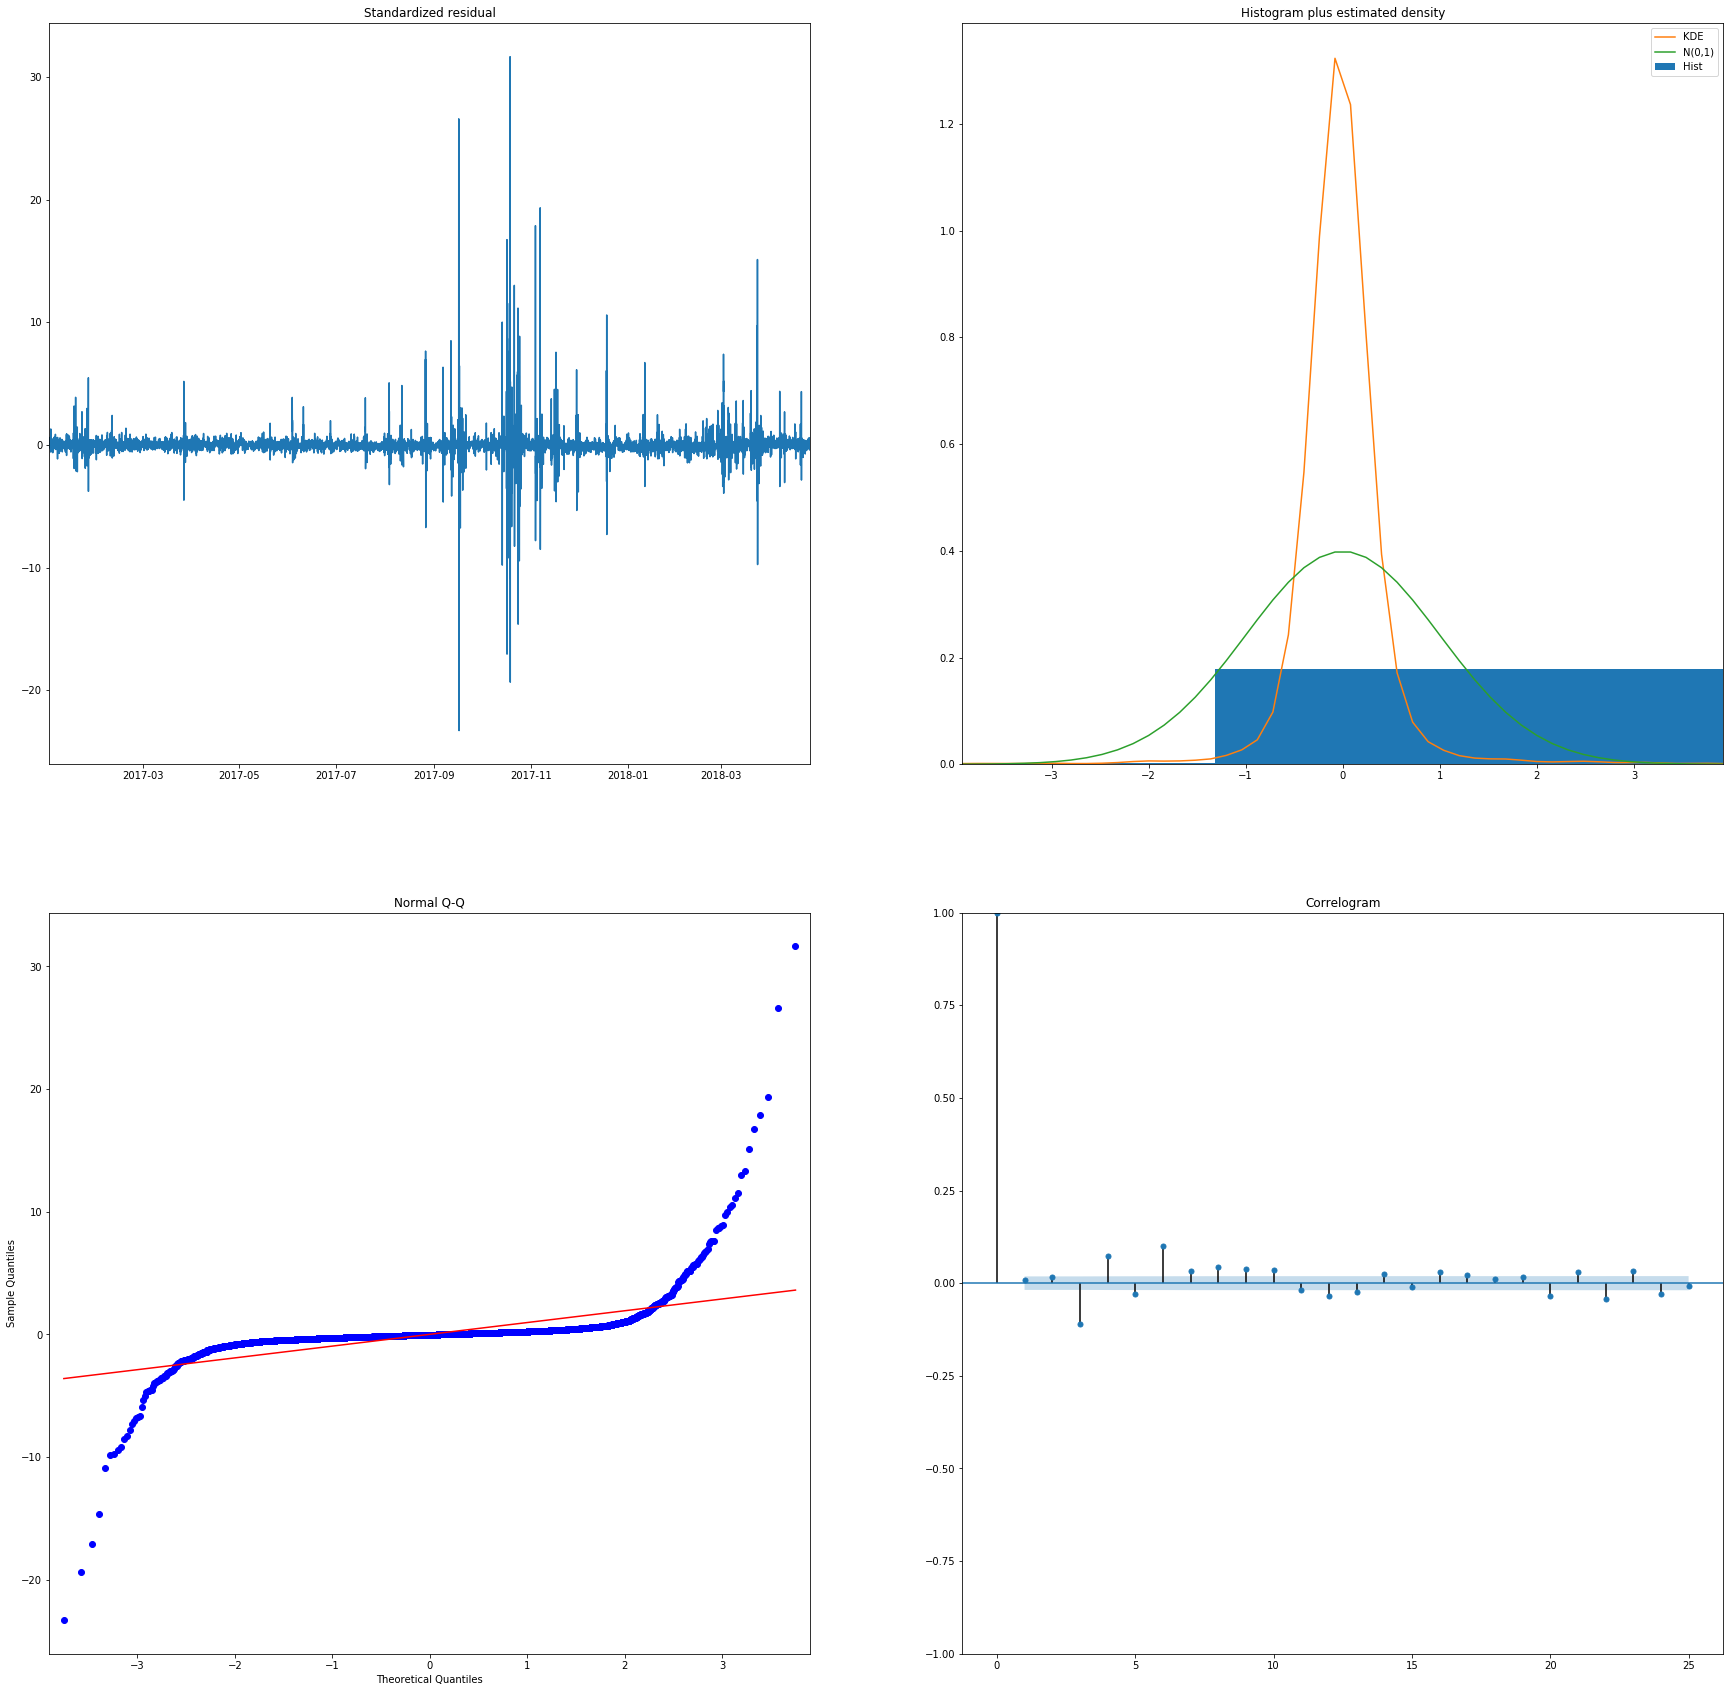

In [106]:
print(results3.plot_diagnostics(lags=25,figsize=(30,30)))

In [110]:
print(results2.test_serial_correlation(method='ljungbox'))

[[[1.44375646e+000 1.44424505e+000 8.12550324e+001 1.39494146e+002
   1.44056247e+002 2.64264731e+002 2.95073085e+002 3.39408617e+002
   3.58394162e+002 3.81498229e+002 3.86392242e+002 4.04650568e+002
   4.14117253e+002 4.33945228e+002 4.34013105e+002 4.68085004e+002
   4.86715120e+002 5.03354255e+002 5.04966675e+002 5.10055588e+002
   5.10712899e+002 5.43601231e+002 5.74026710e+002 1.38127990e+003
   1.38527273e+003 1.39478106e+003 1.39482099e+003 1.39488232e+003
   1.39650694e+003 1.39787049e+003 1.41434512e+003 1.43017986e+003
   1.43605783e+003 1.43611426e+003 1.43622513e+003 1.43784883e+003
   1.44176503e+003 1.45426189e+003 1.45443685e+003 1.46557505e+003]
  [2.29532429e-001 4.85720209e-001 1.65123386e-017 3.62192619e-029
   2.45591168e-029 3.65767100e-054 6.81926711e-060 1.64809538e-068
   1.01211151e-071 8.11906154e-076 4.72397806e-076 3.91856728e-079
   2.32545919e-080 8.77422867e-084 4.82321407e-083 1.78811124e-089
   1.18668020e-092 2.05689839e-095 5.07056047e-095 2.27981859

In [ ]:
#results2.save('sarima20000024') ##tutaj zapisywanie modeli i odczytywanie
#results3.save('sarima3')
#results1.save('sarima1')
##results2.load('sarima20000024')